In [1]:
from torchdrug import datasets
from torchdrug.data.protein import Protein
from Bio import Align
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from tqdm import tqdm
import networkx as nx
import random
from random import sample
import pickle

20:03:57   Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.


/home/ye12/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


# Datasest processing

In [4]:
dataset_loc = "PABP_YEAST_Melamed_2013.csv"
df = pd.read_csv(dataset_loc)
mutants = list(df['mutant'].values)
def get_mutations(list_mutants):
    mutations = []
    for i in list_mutants:
        mutations.extend(i.split(':'))
    return list(set(mutations))

x_train, x_test = train_test_split(mutants, test_size = 0.1, random_state = 42)
x_test, x_val = train_test_split(x_test, test_size = 0.5, random_state = 42)

train_mutations = get_mutations(x_train)
valid_mutations = get_mutations(x_val)
test_mutations = get_mutations(x_test)

# Construct Spectral Property Graph

In [6]:
def create_graph(barcodes):
    G = nx.Graph()


    print("GOING TO INITIALIZE GRAPH")
    #Initialize Graph
    for barcode in barcodes:
        G.add_node(barcode)

    print("GRAPH INITIALIZED")

    #Now we create edges between nodes based on mutational overlap
    for bar_1 in tqdm(barcodes, total=len(barcodes)):
        for bar_2 in barcodes:
            if bar_1 != bar_2:
                for mut in bar_1.split(':'):
                    if mut in bar_2:
                        G.add_edge(bar_1, bar_2)
                        break

    return G

In [7]:
G = create_graph(mutants)

GOING TO INITIALIZE GRAPH
GRAPH INITIALIZED


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37708/37708 [09:43<00:00, 64.60it/s]


In [7]:
pickle.dump(G, open('Graph', 'wb'))

In [8]:
print(G.number_of_nodes())
print(G.number_of_edges())
print(nx.number_connected_components(G))

37708
5269784
134


# Create SPECTRA splits

In [ ]:
G = pickle.load(open('Graph', 'rb'))

In [9]:
def run_independent_set(neighbor_lambda, input_G, tau_number, tau_mut, tau_degree, seed = None, debug=False, random_start = True):
    total_deleted = 0
    
    if seed is not None:
        random.seed(seed)
    
    #THIS MAY CAUSE BUGS! USED TO BE .copy()!
    G = input_G.copy()
    
    #Now we calculated the score for every node, we go to run the algorithm
    independent_set = []
    
    iterations = 0
    
    while not nx.is_empty(G):
        if not random_start:
            chosen_node = max(node_to_score, key=node_to_score.get)
        else:
            chosen_node = sample(list(G.nodes()), 1)[0]
        
        independent_set.append(chosen_node)
        neighbors = G.neighbors(chosen_node)
        neighbors_to_delete = []
        
        for neighbor in neighbors:
            if neighbor_lambda == 1.0:
                neighbors_to_delete.append(neighbor)
            elif neighbor_lambda != 0.0:
                #if random.random() < (0.1+neighbor_lambda) + 0.1 * np.log10(G[chosen_node][neighbor]['weight']+0.1):
                if random.random() < neighbor_lambda:
                    neighbors_to_delete.append(neighbor)

        if debug:
            print(f"Iteration {iterations} Stats")
            print(f"Deleted {len(neighbors_to_delete)} nodes")
            
        for neighbor in neighbors_to_delete:
            G.remove_node(neighbor)
        
        if chosen_node not in neighbors_to_delete:
            G.remove_node(chosen_node)
    
        iterations += 1

    if debug:
        print(f"Total deleted {total_deleted}")
    return independent_set

## Cross-split overlap definition

In [10]:
def calculate_proportion(x_train, x_test):
 
    def flatten(l):
        return [item for sublist in l for item in sublist]
    
    
    one = flatten([i.split(':') for i in x_train])
    two = flatten([i.split(':') for i in x_test])
    
    combined_mutations = list(set(one + two))

    num_overlap = 0
    for i in combined_mutations:
        if i in one and i in two:
            num_overlap += 1
    
    return num_overlap/len(combined_mutations)

In [ ]:
calculated_proportions = []
lambda_params = []
number_samples = []

for lambda_param in np.arange(0, 1.05, 0.025):
    lambda_params.append(lambda_param)
    result = run_independent_set(lambda_param, G, 0, 0, 0)
    x_train ,x_test = train_test_split(result,test_size=0.2) 
    proportion = calculate_proportion(x_train, x_test)
    calculated_proportions.append(proportion)
    number_samples.append(len(result))
    
    print(f"{lambda_param}\t{proportion}\t{len(result)}")
    result_file = open(f"rrm_splits/lambda_{lambda_param}.txt", "w")
    result_file.write(f"{lambda_param}\t{proportion}\t{len(result)}\n")
    result_file.write(f"Train: {x_train}\n")
    result_file.write(f"Test: {x_test}\n")
    result_file.close()

0.0	0.7372384937238494	37693
0.025	0.6408746846089151	11846
0.05	0.5912531539108494	7966
0.07500000000000001	0.5785472972972973	6286
0.1	0.553030303030303	5220
0.125	0.5105130361648444	4506
0.15000000000000002	0.49325463743676223	3998
0.17500000000000002	0.4915254237288136	3601
0.2	0.4543147208121827	3302
0.225	0.44229149115417016	3099
0.25	0.41271186440677965	2853
0.275	0.4170896785109983	2692
0.30000000000000004	0.3984835720303286	2564
0.325	0.3732876712328767	2357
0.35000000000000003	0.36712095400340716	2248
0.375	0.350471293916024	2157
0.4	0.3423344947735192	2025
0.42500000000000004	0.333616298811545	1989
0.45	0.31320103537532357	1878
0.47500000000000003	0.306070826306914	1838
0.5	0.30120481927710846	1742
0.525	0.2905982905982906	1687
0.55	0.2662671232876712	1640
0.5750000000000001	0.2524357838795394	1530
0.6000000000000001	0.25324114088159033	1509
0.625	0.21928327645051193	1493
0.65	0.22735042735042735	1432
0.675	0.20324508966695132	1410
0.7000000000000001	0.20508326029798424	1311

In [13]:
import pickle
pickle.dump(calculated_proportions, open('calc_prop', 'wb'))
pickle.dump(lambda_params, open('lambda_params', 'wb'))
pickle.dump(number_samples, open('number_samples', 'wb'))

# Plot Results

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pickle

lambda_params = pickle.load(open('lambda_params', 'rb'))
number_samples = pickle.load(open('number_samples', 'rb'))
calculated_proportions = pickle.load(open('calc_prop', 'rb'))

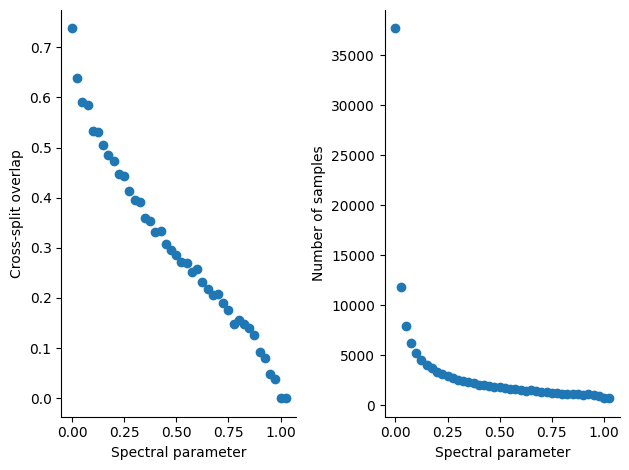

In [2]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=False)
ax1.scatter(lambda_params, calculated_proportions)
ax1.set_ylabel('Cross-split overlap')
ax1.set_xlabel('Spectral parameter')
ax1.spines[['right', 'top']].set_visible(False)
ax2.scatter(lambda_params, number_samples)
ax2.set_ylabel('Number of samples')
ax2.set_xlabel('Spectral parameter')
ax2.spines[['right', 'top']].set_visible(False)
plt.tight_layout()
plt.savefig('ProteinGym_RRM_Stats.pdf')

In [16]:
def find_closest(overlap, x, y):
    min_difference = 1000000
    best_overlap = None
    best_param = None
    
    
    for i,j in zip(x, y):
        if abs(overlap - j) < min_difference:
            best_param = i
            best_overlap = j
            min_difference = abs(overlap - j)
    
    print(f"{best_overlap} and {best_param} for {overlap}")

In [17]:
find_closest(0.62, lambda_params, calculated_proportions)

0.639261744966443 and 0.025 for 0.62
